In [25]:
import pandas as pd
import numpy as np
import geopandas as gpd
from geopy.geocoders import GoogleV3
from geopy.distance import geodesic
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

In [2]:
# Load your dataset
df = pd.read_csv('OYO_crosschecked.csv')
df.head()

,State,LGA,Ward,PU-Code,PU-Name,Accredited_Voters,Registered_Voters,Results_Found,Transcription_Count,Result_Sheet_Stamped,Result_Sheet_Corrected,Result_Sheet_Invalid,Result_Sheet_Unclear,Result_Sheet_Unsigned,APC,LP,PDP,NNPP,Results_File
0,OYO,AFIJIO,ILORA I,30-01-01-003,BODE OPEN SPACE II,251,778,True,-1,False,False,False,False,UNKNOWN,127,24,66,1,https://docs.inecelectionresults.net/elections...
1,OYO,AFIJIO,ILORA I,30-01-01-004,BODE OPEN SPACE II,251,778,True,-1,False,False,False,False,UNKNOWN,138,12,45,0,https://docs.inecelectionresults.net/elections...
2,OYO,AFIJIO,ILORA II,30-01-02-001,AKINDELE OPEN SPACE I,167,471,True,-1,False,False,False,False,UNKNOWN,104,8,43,0,https://inec-cvr-cache.s3.eu-west-1.amazonaws....
3,OYO,AFIJIO,ILORA II,30-01-02-002,AKINDELE OPEN SPACE II,209,603,True,-1,False,True,False,False,UNKNOWN,110,18,49,0,https://inec-cvr-cache.s3.eu-west-1.amazonaws....
4,OYO,AFIJIO,ILORA II,30-01-02-003,AKINDELE OPEN SPACE II,209,603,True,-1,False,False,False,False,UNKNOWN,132,11,59,0,https://inec-cvr-cache.s3.eu-west-1.amazonaws....


In [3]:
# If latitude and longitude are missing, use geocoding (Example with Google Maps API)
geolocator = GoogleV3(api_key='your_google_maps_api_key')

In [4]:
 #Geocoding (if necessary)
if 'latitude' not in df.columns or 'longitude' not in df.columns:
    np.random.seed(42)
    df['latitude'] = np.random.uniform(low=7.0, high=9.0, size=len(df))
    df['longitude'] = np.random.uniform(low=3.0, high=5.0, size=len(df))

In [5]:
# Print the first few rows after geocoding
print("\nDataFrame after Geocoding:")
print(df.head())


DataFrame after Geocoding:
  State     LGA      Ward       PU-Code                 PU-Name  \
0   OYO  AFIJIO   ILORA I  30-01-01-003      BODE OPEN SPACE II   
1   OYO  AFIJIO   ILORA I  30-01-01-004      BODE OPEN SPACE II   
2   OYO  AFIJIO  ILORA II  30-01-02-001   AKINDELE OPEN SPACE I   
3   OYO  AFIJIO  ILORA II  30-01-02-002  AKINDELE OPEN SPACE II   
4   OYO  AFIJIO  ILORA II  30-01-02-003  AKINDELE OPEN SPACE II   

   Accredited_Voters  Registered_Voters  Results_Found  Transcription_Count  \
0                251                778           True                   -1   
1                251                778           True                   -1   
2                167                471           True                   -1   
3                209                603           True                   -1   
4                209                603           True                   -1   

   Result_Sheet_Stamped  ...  Result_Sheet_Invalid  Result_Sheet_Unclear  \
0                 

In [6]:
# Perform clustering
coords = df[['latitude', 'longitude']].values
db = DBSCAN(eps=0.01, min_samples=1, metric='haversine').fit(np.radians(coords))
df['cluster'] = db.labels_

# Print the first few row after clustering 
print("\nDataFrame after Clustering:")
print(df.head())


DataFrame after Clustering:
  State     LGA      Ward       PU-Code                 PU-Name  \
0   OYO  AFIJIO   ILORA I  30-01-01-003      BODE OPEN SPACE II   
1   OYO  AFIJIO   ILORA I  30-01-01-004      BODE OPEN SPACE II   
2   OYO  AFIJIO  ILORA II  30-01-02-001   AKINDELE OPEN SPACE I   
3   OYO  AFIJIO  ILORA II  30-01-02-002  AKINDELE OPEN SPACE II   
4   OYO  AFIJIO  ILORA II  30-01-02-003  AKINDELE OPEN SPACE II   

   Accredited_Voters  Registered_Voters  Results_Found  Transcription_Count  \
0                251                778           True                   -1   
1                251                778           True                   -1   
2                167                471           True                   -1   
3                209                603           True                   -1   
4                209                603           True                   -1   

   Result_Sheet_Stamped  ...  Result_Sheet_Unclear  Result_Sheet_Unsigned  \
0               

In [7]:
# Function to find neighbors within a cluster
def find_cluster_neighbours(cluster_data, radius=1):
    neighbours = []
    for index, row in cluster_data.iterrows():
        centre_point = (row['latitude'], row['longitude'])
        local_neighbours = []
        for idx, r in cluster_data.iterrows():
            if index != idx:
                point = (r['latitude'], r['longitude'])
                if geodesic(centre_point, point).km <= radius:
                    local_neighbours.append(idx)
        neighbours.append(local_neighbours)
    return neighbours


In [11]:
# Apply neighbor identification within each cluster
clustered_groups = df.groupby('cluster')
df['neighbours'] = pd.Series([])

for cluster_label, cluster_data in clustered_groups:
    if cluster_label != -1:
        neighbours_list = find_cluster_neighbours(cluster_data)
        for index, neighbours in zip(cluster_data.index, neighbours_list):
            df.at[index, 'neighbours'] = neighbours

# Print the first few rows after neighbor identification
print("\nDataFrame after Neighbor Identification:")
print(df.head())


DataFrame after Neighbor Identification:
  State     LGA      Ward       PU-Code                 PU-Name  \
0   OYO  AFIJIO   ILORA I  30-01-01-003      BODE OPEN SPACE II   
1   OYO  AFIJIO   ILORA I  30-01-01-004      BODE OPEN SPACE II   
2   OYO  AFIJIO  ILORA II  30-01-02-001   AKINDELE OPEN SPACE I   
3   OYO  AFIJIO  ILORA II  30-01-02-002  AKINDELE OPEN SPACE II   
4   OYO  AFIJIO  ILORA II  30-01-02-003  AKINDELE OPEN SPACE II   

   Accredited_Voters  Registered_Voters  Results_Found  Transcription_Count  \
0                251                778           True                   -1   
1                251                778           True                   -1   
2                167                471           True                   -1   
3                209                603           True                   -1   
4                209                603           True                   -1   

   Result_Sheet_Stamped  ...  Result_Sheet_Unsigned  APC  LP PDP  NNPP  \
0     

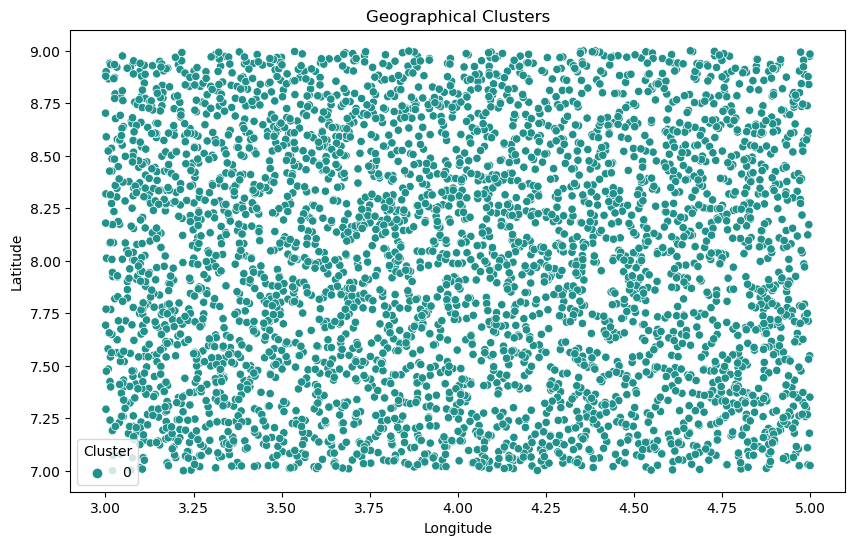

In [26]:
# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue='cluster', palette='viridis', data=df, legend='full')
plt.title('Geographical Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster')
plt.show()

In [13]:
# Function to calculate outlier scores
def calculate_outlier_scores(df):
    for party in ['APC', 'LP', 'PDP', 'NNPP']:
        outlier_scores = []
        for index, row in df.iterrows():
            neighbour_indexes = row['neighbours']
            if len(neighbour_indexes) > 0:
                neighbours = df.loc[neighbour_indexes]
                neighbour_votes = neighbours[party].mean()
                outlier_score = abs(row[party] - neighbour_votes)
            else:
                outlier_score = np.nan
            outlier_scores.append(outlier_score)
        df[f'{party}_outlier_score'] = outlier_scores

# Calculating outlier scores
calculate_outlier_scores(df)

# Print the first few rows after calculating outlier scores
print("\nDataFrame after Calculating Outlier Scores:")
print(df.head())


DataFrame after Calculating Outlier Scores:
  State     LGA      Ward       PU-Code                 PU-Name  \
0   OYO  AFIJIO   ILORA I  30-01-01-003      BODE OPEN SPACE II   
1   OYO  AFIJIO   ILORA I  30-01-01-004      BODE OPEN SPACE II   
2   OYO  AFIJIO  ILORA II  30-01-02-001   AKINDELE OPEN SPACE I   
3   OYO  AFIJIO  ILORA II  30-01-02-002  AKINDELE OPEN SPACE II   
4   OYO  AFIJIO  ILORA II  30-01-02-003  AKINDELE OPEN SPACE II   

   Accredited_Voters  Registered_Voters  Results_Found  Transcription_Count  \
0                251                778           True                   -1   
1                251                778           True                   -1   
2                167                471           True                   -1   
3                209                603           True                   -1   
4                209                603           True                   -1   

   Result_Sheet_Stamped  ...  NNPP  \
0                 False  ...     1   
1

In [18]:
# Sorting the dataset by outlier scores
sorted_df = df.sort_values(by=['APC_outlier_score', 'LP_outlier_score', 'PDP_outlier_score', 'NNPP_outlier_score'], ascending=False)



# Print the first few rows of the sorted dataset
print("\nSorted DataFrame by Outlier Scores:")
print(sorted_df.head())


Sorted DataFrame by Outlier Scores:
     State         LGA                    Ward       PU-Code  \
1860   OYO         IDO     APETE/AYEGUN/AWOTAN  30-14-04-006   
2710   OYO  OLORUNSOGO            OPA/OGUNNIYI  30-24-07-006   
2015   OYO      ISEYIN                 ISALU I  30-16-07-006   
3747   OYO         IDO  ERINWUSI/KOGUO/ODETOLA  30-14-06-010   
2030   OYO      ISEYIN                  KOSO I  30-16-09-008   

                                         PU-Name  Accredited_Voters  \
1860               I.D.C. PRIMARY SCHOOL, AWOTAN                668   
2710                     MATERNITY CENTRE, TOOLO                185   
2015                      R.C.M. SCHOOL, ISALU I                128   
3747  SAINT PAUL'S ANGLICAN SCHOOL ARAROMI IDOWU                 13   
2030      BAPTIST SECONDARY GRAMMAR SCHOOL, KOSO                517   

      Registered_Voters  Results_Found  Transcription_Count  \
1860               3215           True                   -1   
2710                618  

In [21]:
import os

# Define the file path
sorted_file_path = 'C:/Users/Adewale Oguntola/Desktop/Wale Projects/Data Science Project/sorted_outlier_scores.xlsx'

# Save the sorted dataset
sorted_df.to_excel(sorted_file_path, index=False)

print(f"File saved at: {sorted_file_path}")


File saved at: C:/Users/Adewale Oguntola/Desktop/Wale Projects/Data Science Project/sorted_outlier_scores.xlsx


C:\Users\Adewale Oguntola\anaconda3\envs\Adewale\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Adewale Oguntola\anaconda3\envs\Adewale\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Adewale Oguntola\anaconda3\envs\Adewale\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Adewale Oguntola\anaconda3\envs\Adewale\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option i

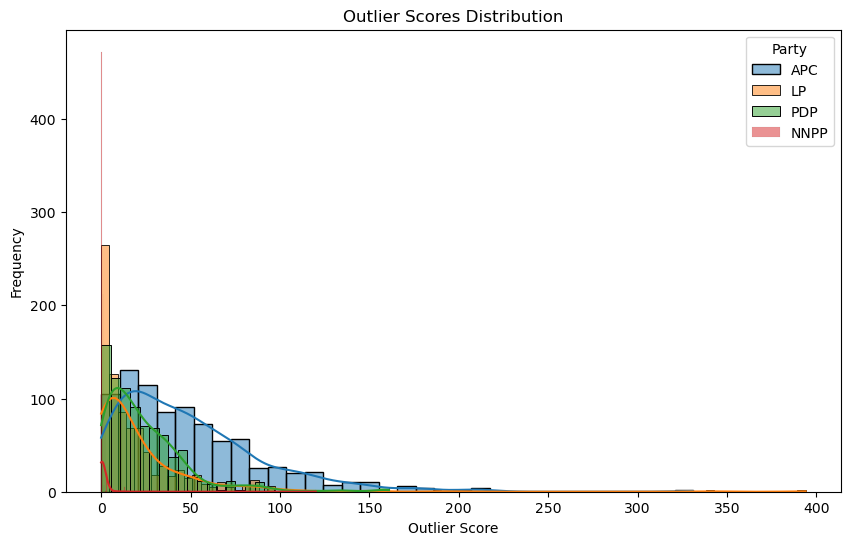

In [27]:
# Visualize the outlier scores for each party
plt.figure(figsize=(10, 6))
for party in ['APC', 'LP', 'PDP', 'NNPP']:
    sns.histplot(sorted_df[f'{party}_outlier_score'].dropna(), kde=True, label=party)

plt.title('Outlier Scores Distribution')
plt.xlabel('Outlier Score')
plt.ylabel('Frequency')
plt.legend(title='Party')
plt.show()

In [30]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world

C:\Users\Adewale Oguntola\AppData\Local\Temp\ipykernel_15208\2073187333.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


C:\Users\Adewale Oguntola\AppData\Local\Temp\ipykernel_15208\1394657783.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


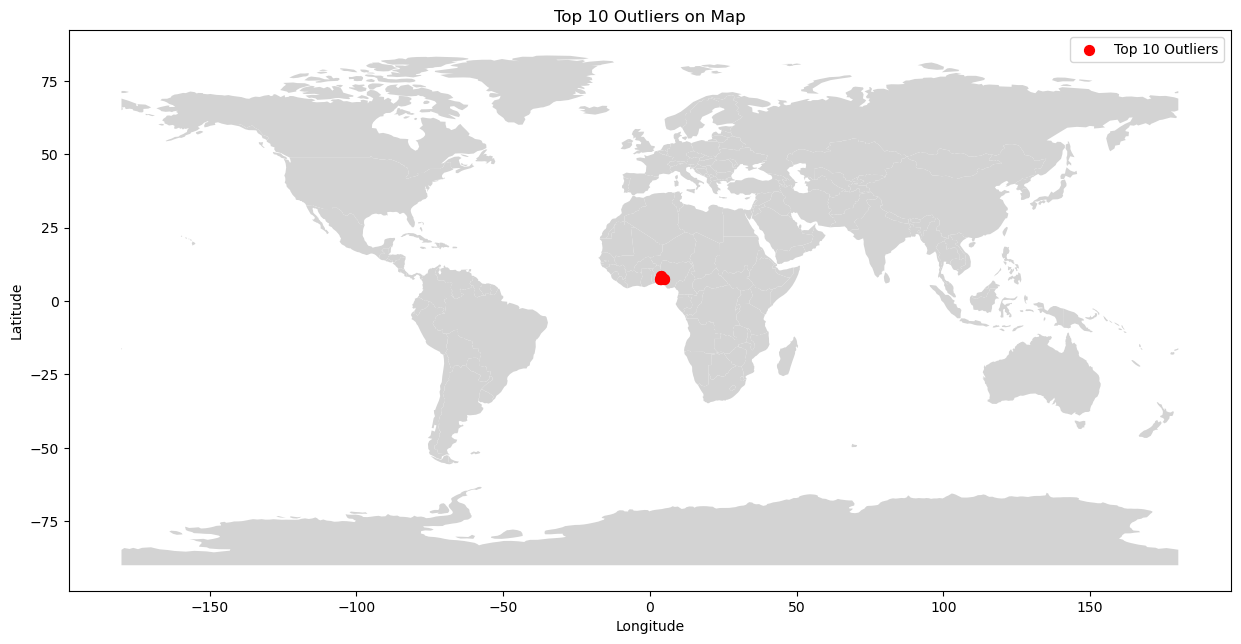

In [28]:
# Visualize the top 10 outliers on a geographical map
top_outliers = sorted_df.head(10)
gdf = gpd.GeoDataFrame(top_outliers, geometry=gpd.points_from_xy(top_outliers.longitude, top_outliers.latitude))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, color='red', markersize=50, label='Top 10 Outliers')
plt.title('Top 10 Outliers on Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()